# Import?

In [ ]:
# # !pip install googletrans==4.0.0-rc1             # package version update
# import googletrans
# from googletrans import Translator
# import pandas as pd
# import numpy as np

# import re
# import string
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import word_tokenize
# from nltk.stem import PorterStemmer
# from nltk.tokenize import sent_tokenize, word_tokenize
# # nltk.download('wordnet')
# # nltk.download('omw-1.4')


# from PIL import Image
# import matplotlib.pyplot as plt
# from wordcloud import STOPWORDS, WordCloud
# import seaborn as sns


# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import cross_validate
# from sklearn.pipeline import make_pipeline
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation

# Basic Cleaning !

In [155]:
#data                               
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#nlp
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
# from nltk.stem import PorterStemmer
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt')
# nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation

# wordcloud
from PIL import Image
from wordcloud import STOPWORDS, WordCloud

## translation
# import googletrans
# from googletrans import Translator

In [156]:
girls_df = pd.read_csv('../data/major_girlgroups_final.csv')
print(girls_df.shape)
girls_df.head(2)

(6034, 10)


artist_id               artist_name  album_id  \
0   80026432  소녀시대 (GIRLS' GENERATION)  20528353   
1   80026432  소녀시대 (GIRLS' GENERATION)  20528353   

                          album_title   song_id  \
0  iScreaM Vol.19 : FOREVER 1 Remixes  32704240   
1  iScreaM Vol.19 : FOREVER 1 Remixes  32704241   

                          song_title release_date               song_artist  \
0  FOREVER 1 (Matisse & Sadko Remix)   2022-11-17  소녀시대 (GIRLS' GENERATION)   
1          FOREVER 1 (Aiobahn Remix)   2022-11-17  소녀시대 (GIRLS' GENERATION)   

                                         song_lyrics  year  
0  [FOREVER 1\r\nIt's love It's love\r\nWe're not...  2022  
1  [FOREVER 1\r\nIt's love It's love\r\nWe're not...  2022

In [157]:
def preprocessing(sentence):
    sentence = str(sentence)
    sentence = sentence.strip()
    sentence = sentence.lower()
    sentence = ''.join(char for char in sentence if not char.isdigit())
    sentence = sentence.replace('\r\n', ' ')
    
    manual_sw = ['amp']

    manual_sw = ['내', '나를', '나의', '너의', '난', '날', '내가', '너','나', '그', '니', '걸', '거야', '수', '다', '더', "n't",  'l', 'u', '-',
                'na', 'ah', 'e','m', 'uh', 'eh', 's', 'la', 'a', 'o', 'ta', 't', 'oh', 'du', 'yeah', '’', 
                 '널', '네', '니가', '네가', '널', '너를', '넌', '내게', '이','-','na', 'ah', 'e','m', 'uh', 'eh', 's', 'la', 'a', 'o', 'ta', 't', 'oh', 'du', 'yeah', '’', 
                '“', 'wan', '한', '해']
    
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, ' ') 

    tokenized_sentence = word_tokenize(sentence) ## tokenize 
    stop_words = list(set(stopwords.words('english'))) ## define stopwords
    stop_words.extend(manual_sw)
    
    tokenized_sentence_cleaned = [ ## remove stopwords
        w for w in tokenized_sentence if not w in stop_words
    ]
    
    return ' '.join(tokenized_sentence_cleaned)


In [158]:
girls_df['song_lyrics'] = girls_df['song_lyrics'].apply(preprocessing)

In [159]:
# without filtering
total_lyrics = ' '.join(girls_df['song_lyrics'])
len(total_lyrics)

3376387

In [201]:
df = girls_df.copy()
df['album_title'] = df['album_title'].str.lower()
df['song_title'] = df['song_title'].str.lower()

In [202]:
df['song_lyrics'] = df['song_lyrics'].apply(preprocessing)

In [203]:
# Feature selection - which columns?
df.columns

Index(['artist_id', 'artist_name', 'album_id', 'album_title', 'song_id',
       'song_title', 'release_date', 'song_artist', 'song_lyrics', 'year'],
      dtype='object')

In [205]:
df = df.sort_values('release_date')
df = df[df['artist_name'] != 'Various Artists']
df = df[df['song_lyrics'] != '']
df = df[df['song_lyrics'] != 'nan']
df = df.drop_duplicates(['artist_id','song_title'], keep='first')
df = df.drop_duplicates(['song_lyrics'])

df = df[~df['album_title'].str.contains('remix')]
df = df[~df['album_title'].str.contains('japan')]
df = df[~df['album_title'].str.contains('일본')]
df = df[~df['album_title'].str.contains('live')]
df = df[~df['album_title'].str.contains('ost')]
df = df[~df['album_title'].str.contains('inst')]
df = df[~df['album_title'].str.contains('repackage')]
df = df[~df['album_title'].str.contains('chinese')]

df = df[~df['song_title'].str.contains('권리없는')]
df = df[~df['song_title'].str.contains('remix')]
df = df[~df['song_title'].str.contains('japan')]
df = df[~df['song_title'].str.contains('chinese')]
df = df[~df['song_title'].str.contains('inst')]
df.reset_index()
df.shape

(2312, 10)

In [207]:
print('number of rows - original: ', len(girls_df))
print('number of rows - after filtering: ', len(df))

number of rows - original:  6034
number of rows - after filtering:  2312


In [208]:
print('number of rows - original: ', len(' '.join(girls_df['song_lyrics'])))
print('number of rows - after filtering: ', len(' '.join(df['song_lyrics'])))

number of rows - original:  3376387
number of rows - after filtering:  1714194


In [166]:
# artist_df = pd.read_csv('../data/girlgroup_list.csv')

# artist_df = artist_df.dropna()
# artist_df['Artist ID'] = artist_df['Artist ID'].astype(int)
# artist_df.reset_index(inplace=True, drop=True)

# group_lst = artist_df[artist_df['Category']=='Idol']['Artist ID'].tolist()
# solo_lst = artist_df[artist_df['Category']=='Solo']['Artist ID'].tolist()

# By Groups - Keywords

In [209]:
artist_df = pd.read_csv('../data/girlgroup_list.csv')

artist_df = artist_df.dropna()
artist_df['Artist ID'] = artist_df['Artist ID'].astype(int)
artist_df.reset_index(inplace=True, drop=True)

In [210]:
df_artist_year = df.groupby(['artist_id', 'year']).sum()['song_lyrics'].reset_index()
df_artist_year = df_artist_year.merge(artist_df, how='left', left_on = 'artist_id', right_on='Artist ID')[['artist_id', 'year', 'English Name', 'song_lyrics']]
df_artist_year = df_artist_year.rename(columns={'English Name': 'artist_name'})

In [211]:
df_artist_album = df.groupby(['artist_id', 'album_title', 'year']).sum()['song_lyrics'].reset_index()
df_artist_album = df_artist_album.merge(artist_df, how='left', left_on = 'artist_id', right_on='Artist ID')[['artist_id', 'year', 'album_title','English Name', 'song_lyrics']]
df_artist_album = df_artist_album.rename(columns={'English Name': 'artist_name'})

In [212]:
df_artist_year

artist_id  year artist_name  \
0         1168  2000         BOA   
1         1168  2001         BOA   
2         1168  2002         BOA   
3         1168  2003         BOA   
4         1168  2004         BOA   
..         ...   ...         ...   
254   80347326  2021       aespa   
255   80347326  2022       aespa   
256   80347326  2023       aespa   
257   80365655  2022       NMIXX   
258   80365655  2023       NMIXX   

                                           song_lyrics  
0    come come come come come come come come 괜히 가슴이...  
1    누구였을까 내서랍 속에 아주 조심스레 편지가 놓여 있네 이름도 없는 편지속엔 그저 ...  
2    아무것도아니라고 나를위로하려했던 너의그런모습이 더욱 힘들게 해 너도 원하고 있잖아 ...  
3    morning sunlight eyes brings life everything w...  
4    바라보는 눈빛도 나즈막한 그대 목소리도 하나같이 너무 좋은 그대 왜 이렇게 설레 일...  
..                                                 ...  
254  닮은 듯한 모습으로 오던 날을 기억하고 있어 그날은 하얀 눈이 소리 없이 내려온 첫...  
255  discussion talking nothing would ever say face...  
256  baby twisted fantasy buckle take seat hold tig...  
257  dat 이제야 벗겨지는 veil thanks waitin hi 보면 모두가 pani...  
258  love like love like love like love right back ...  

[259 rows x 4 columns]

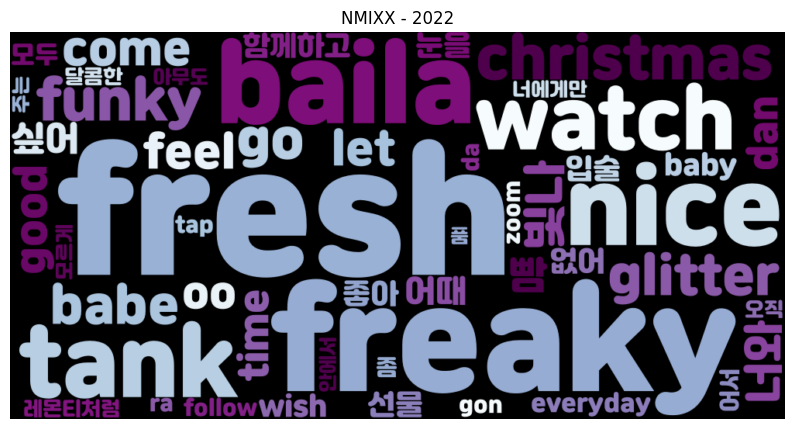

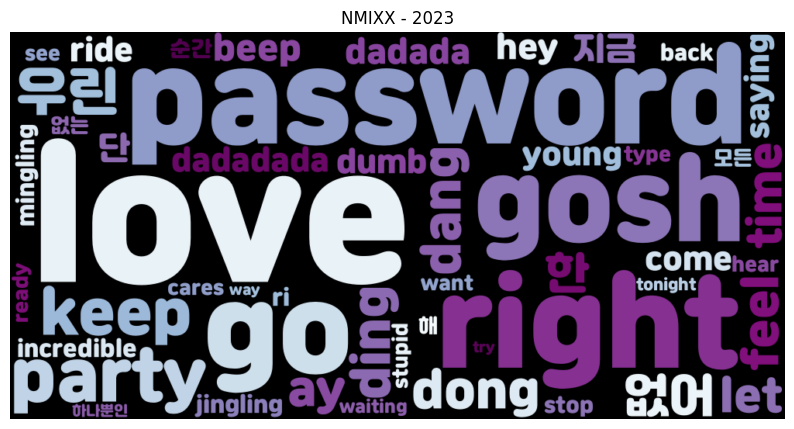

In [213]:
wc_by_year(df_artist_year, 80365655)

In [233]:
def wc_by_album(df, artist_id_):
    
    
    df = df[df['artist_id']==artist_id_]
    df = df.sort_values('year')
    lyric_lst = [i for i in df.song_lyrics]
    year_lst = [i for i in df.year]
    album_lst = [i for i in df.album_title]
    
    artist_name_ = df.artist_name.iloc[0]
    
    
    for lyric in lyric_lst:
        word_cloud = WordCloud(font_path='../data/font/JalnanOTF.otf', width = 1000, height = 500, 
        colormap='prism', background_color= 'white', max_words=30, collocations = False).generate(lyric)

        plt.figure(figsize = (10,8))
        plt.imshow(word_cloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f'{artist_name_} - {df.album_title.iloc[lyric_lst.index(lyric)]} - {year_lst[lyric_lst.index(lyric)]}')
        plt.show()
        
        yearr=year_lst[lyric_lst.index(lyric)]
#         word_cloud.to_file(f"data/final_wordcloud_png/{yearr}_wordcloud.png")

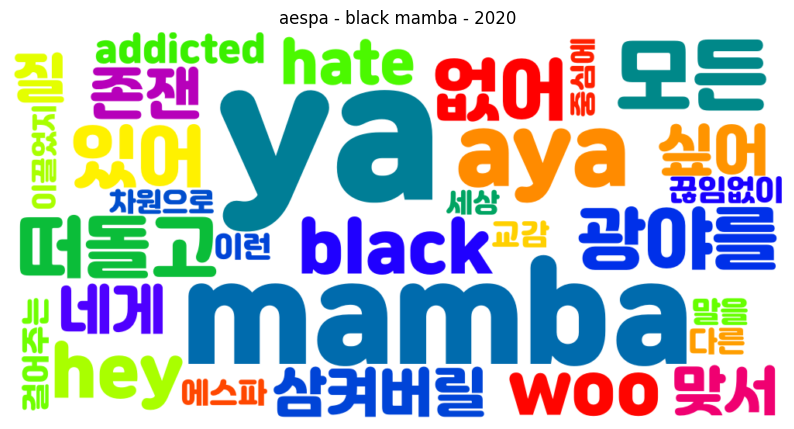

/Users/jiwonshin/.pyenv/versions/3.10.6/envs/test_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50557 (\N{HANGUL SYLLABLE YAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jiwonshin/.pyenv/versions/3.10.6/envs/test_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49549 (\N{HANGUL SYLLABLE SOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


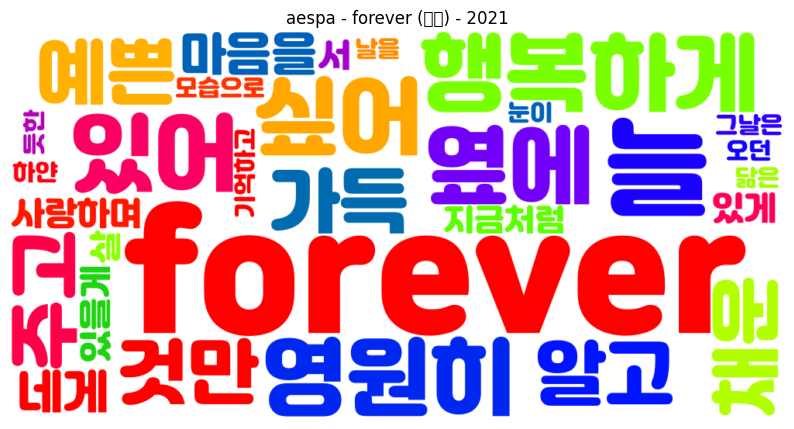

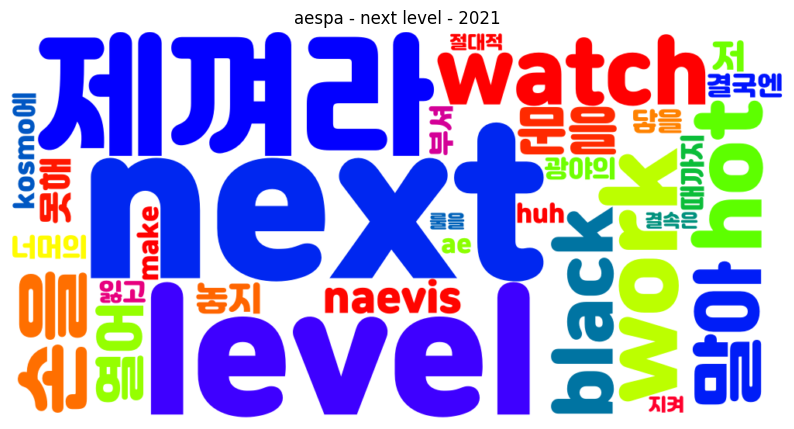

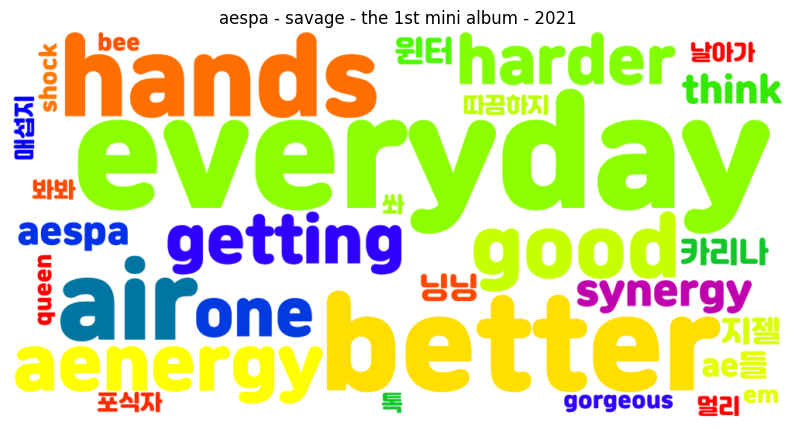

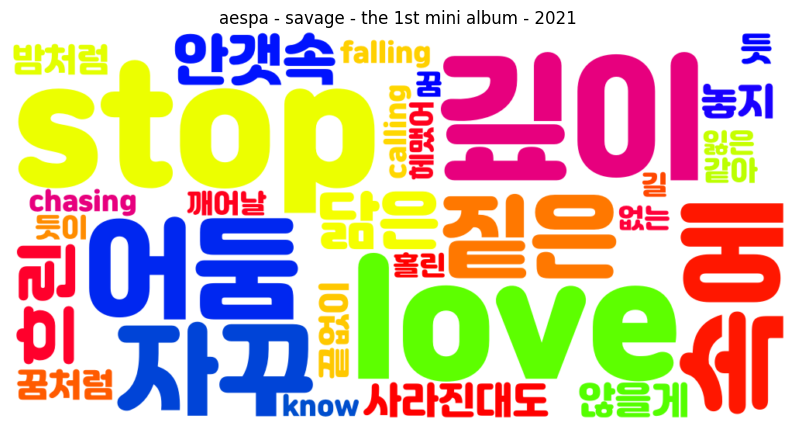

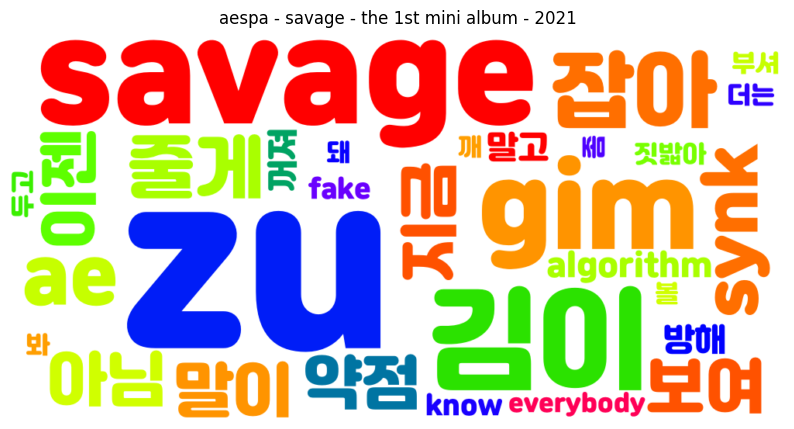

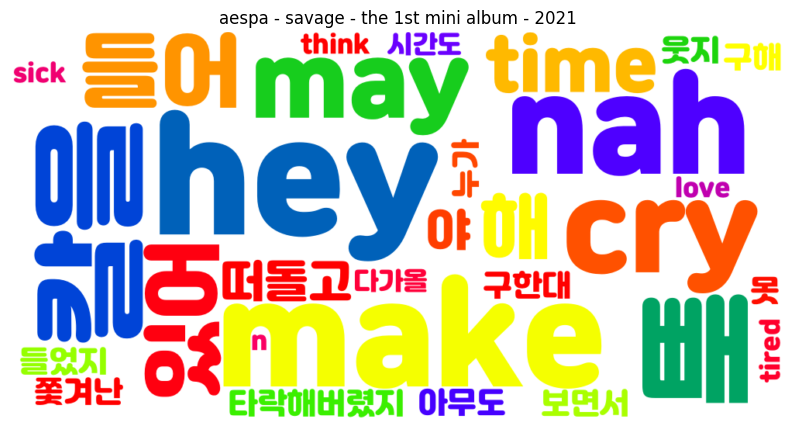

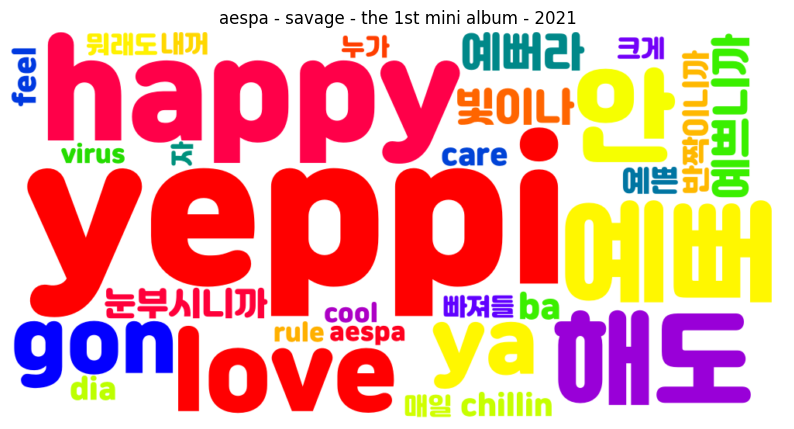

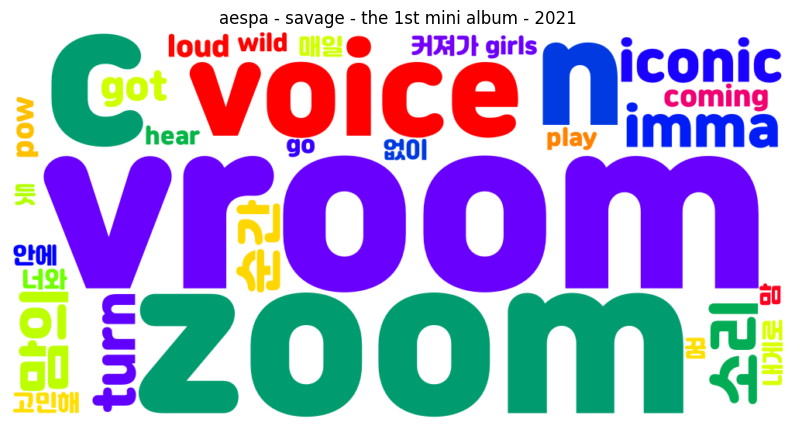

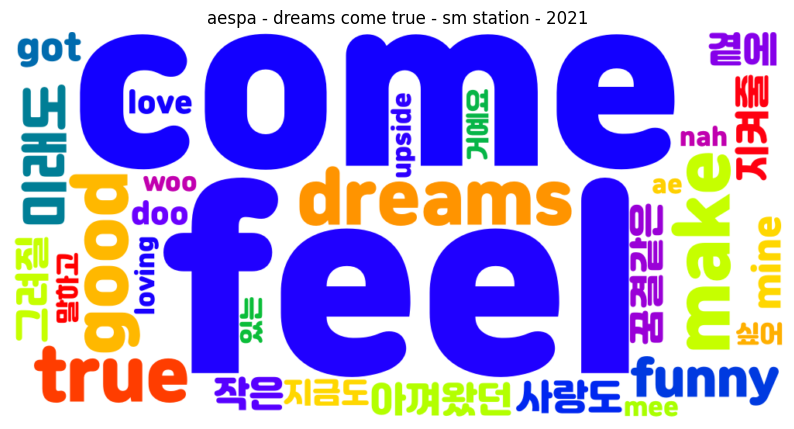

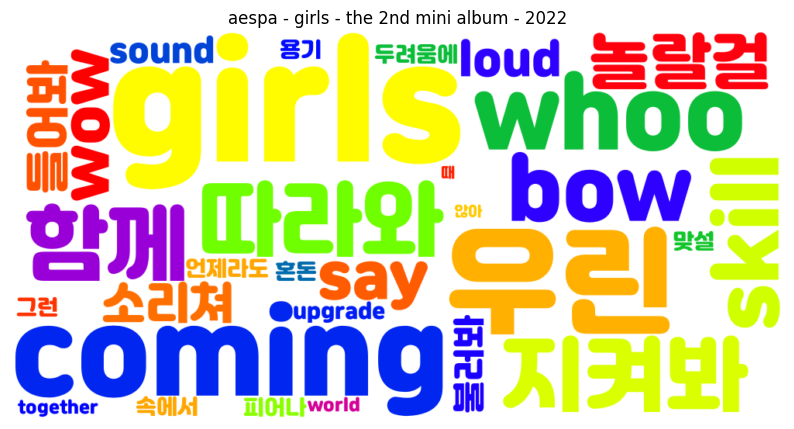

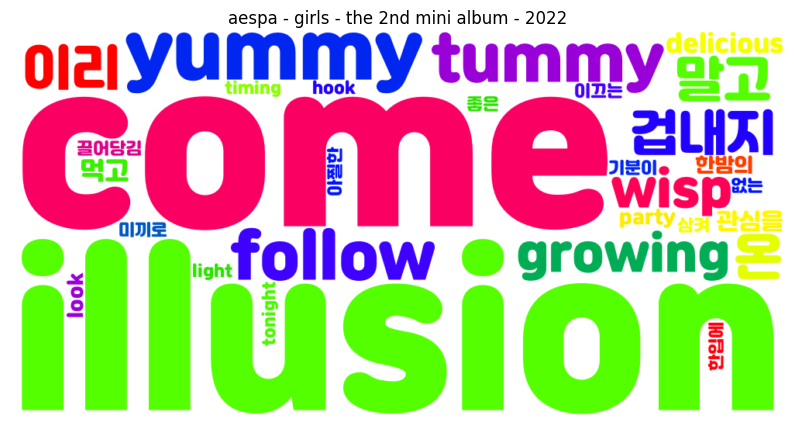

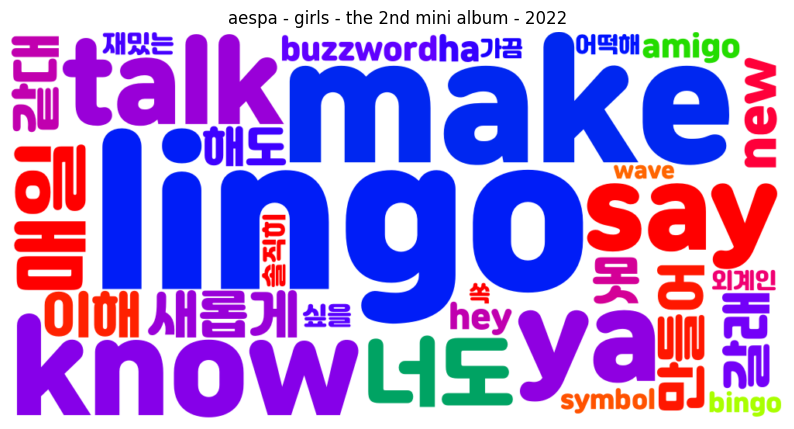

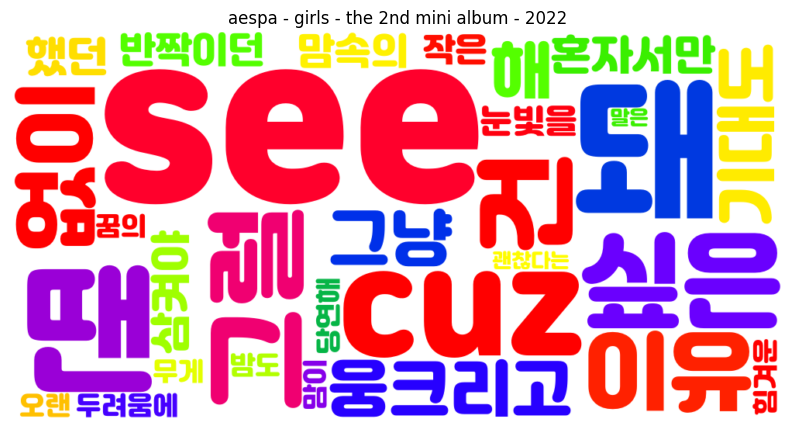

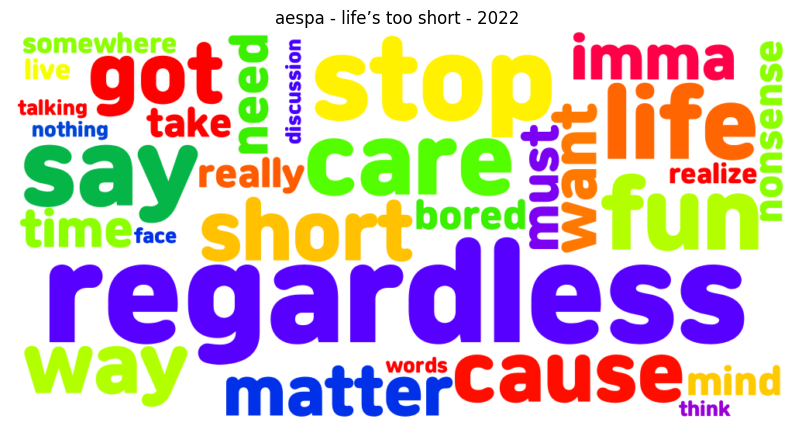

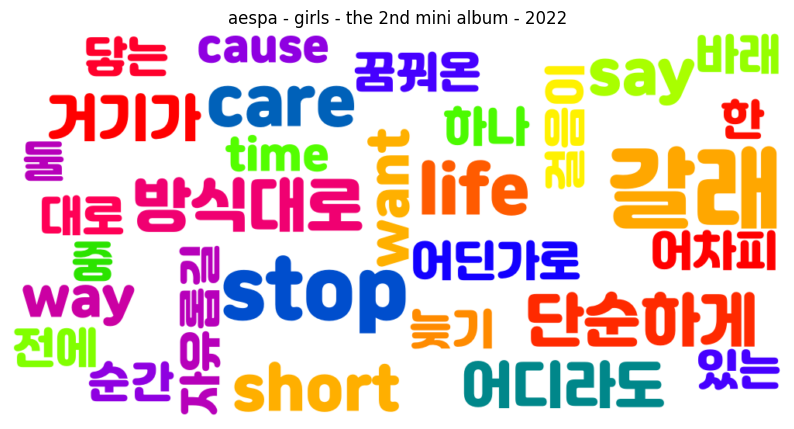

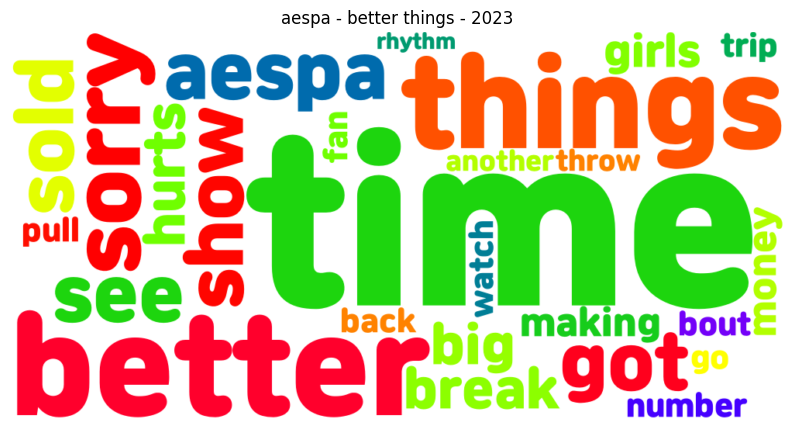

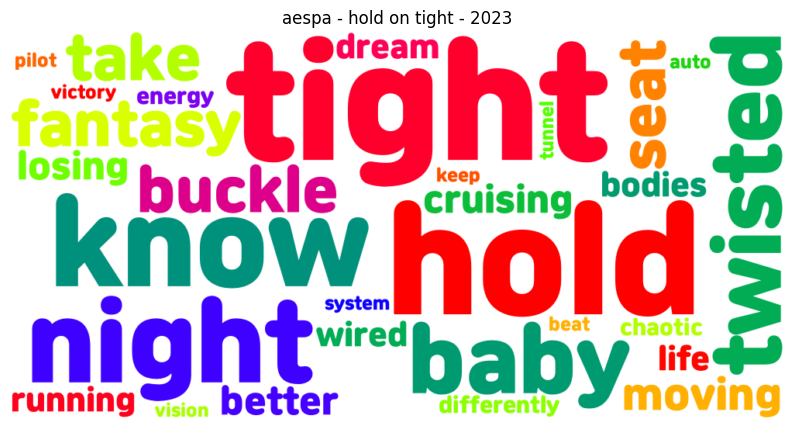

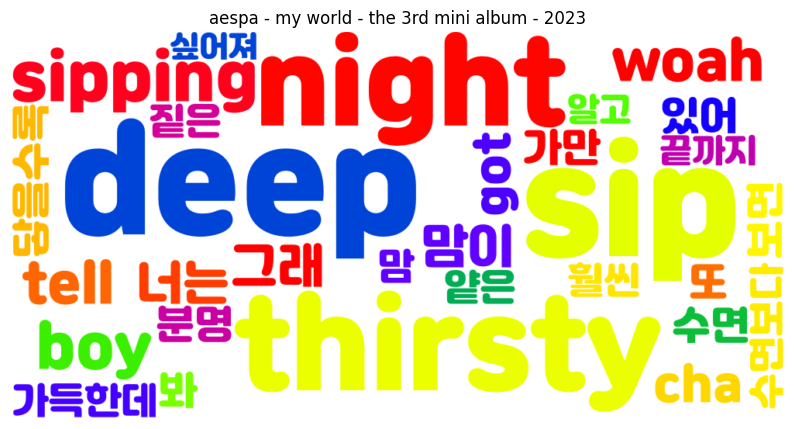

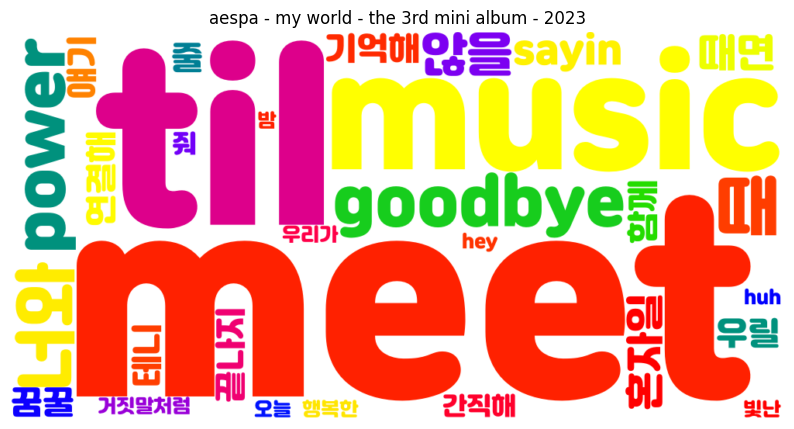

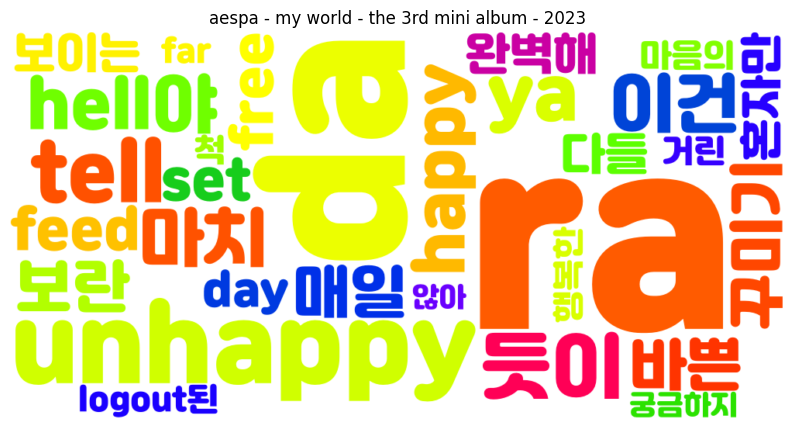

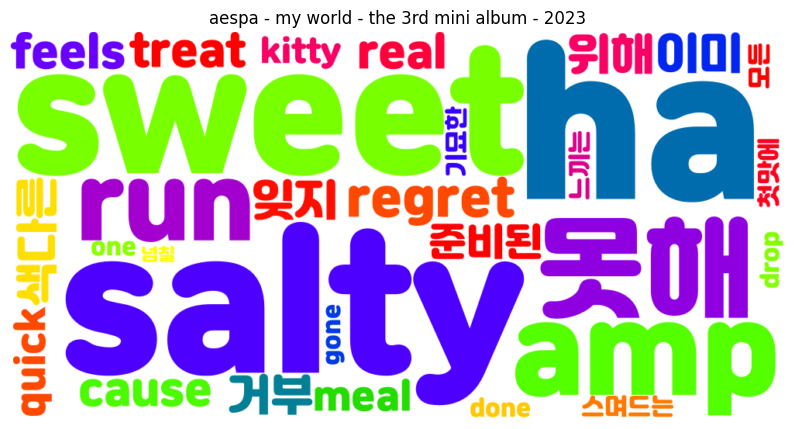

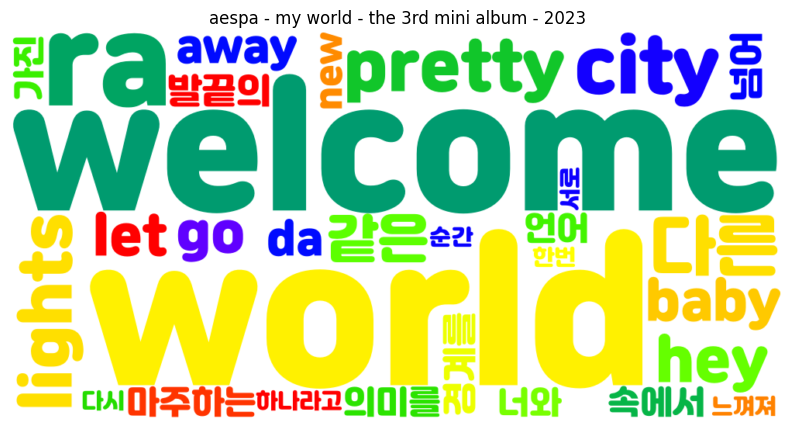

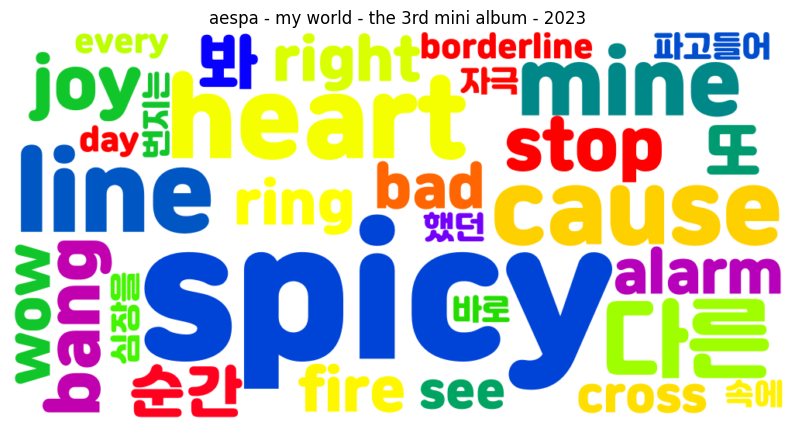

/Users/jiwonshin/.pyenv/versions/3.10.6/envs/test_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jiwonshin/.pyenv/versions/3.10.6/envs/test_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53011 (\N{HANGUL SYLLABLE KES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jiwonshin/.pyenv/versions/3.10.6/envs/test_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47788 (\N{HANGUL SYLLABLE MON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jiwonshin/.pyenv/versions/3.10.6/envs/test_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jiwonshin/.pyenv/versions/3.10.6/envs/test_env/lib/pyt

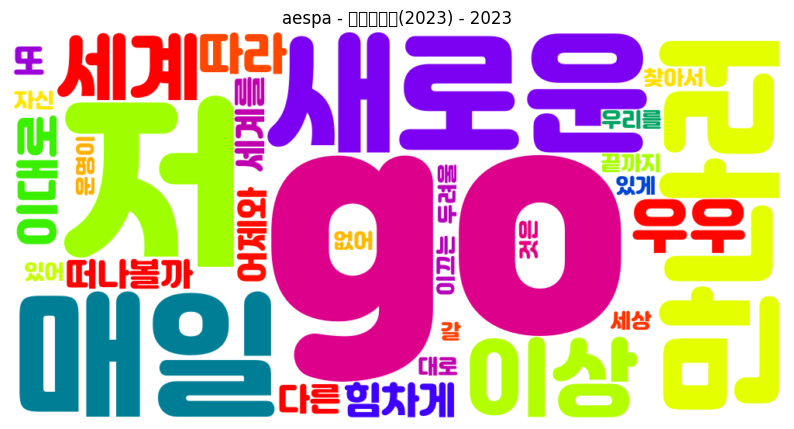

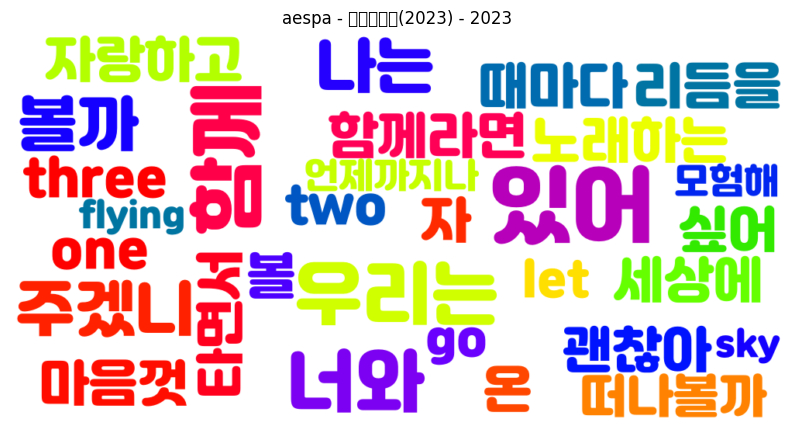

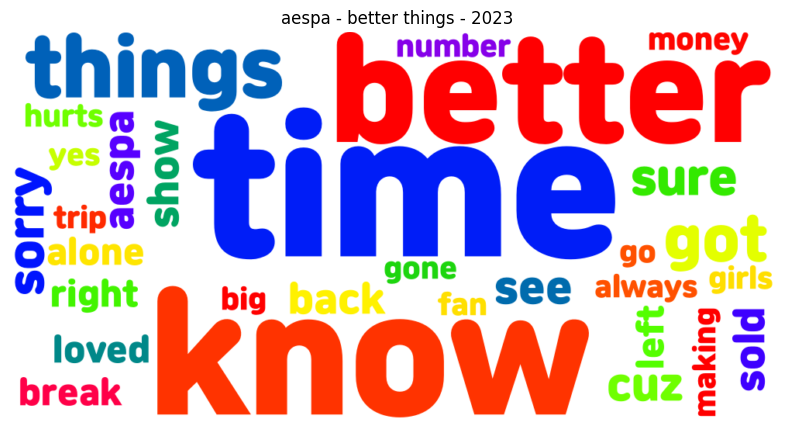

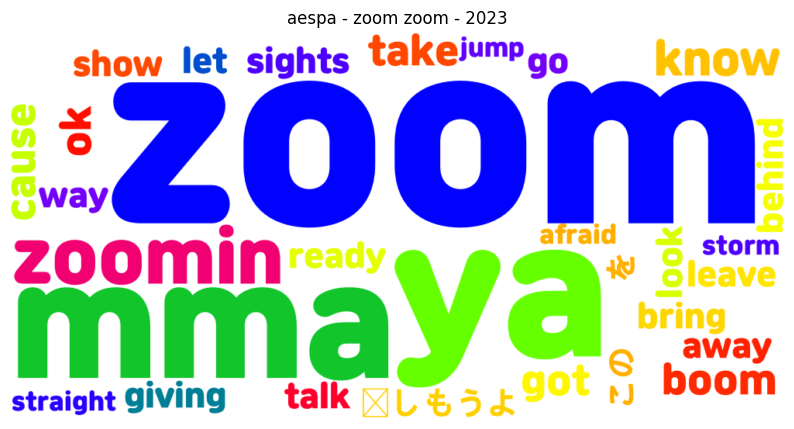

In [234]:
wc_by_album(df, 80347326)

# Translation

In [ ]:
# !pip install spacy_langdetect

In [ ]:
# pip install --upgrade google-cloud-translate

In [18]:
from google.cloud import translate

def translate_text(target: str, text: str) -> dict:
    """Translates text into the target language.

    Target must be an ISO 639-1 language code.
    See https://g.co/cloud/translate/v2/translate-reference#supported_languages
    """
    from google.cloud import translate_v2 as translate

    translate_client = translate.Client()

    if isinstance(text, bytes):
        text = text.decode("utf-8")

    # Text can also be a sequence of strings, in which case this method
    # will return a sequence of results for each text.
    result = translate_client.translate(text, target_language=target)

    print("Text: {}".format(result["input"]))
    print("Translation: {}".format(result["translatedText"]))
    print("Detected source language: {}".format(result["detectedSourceLanguage"]))

    return result


In [19]:
sample_text = '우리 추억들의 메들리는 멈추지 않아 영원히 really really 친구를 넘어'

In [21]:
translate_text('ko', sample_text)

Forbidden: 403 POST https://translation.googleapis.com/language/translate/v2?prettyPrint=false: Cloud Translation API has not been used in project 221871789903 before or it is disabled. Enable it by visiting https://console.developers.google.com/apis/api/translate.googleapis.com/overview?project=221871789903 then retry. If you enabled this API recently, wait a few minutes for the action to propagate to our systems and retry.

In [20]:
def print_supported_languages(display_language_code: str):
    client = translate.TranslationServiceClient()

    response = client.get_supported_languages(
        parent=PARENT,
        display_language_code=display_language_code,
    )

    languages = response.languages
    print(f" Languages: {len(languages)} ".center(60, "-"))
    for language in languages:
        language_code = language.language_code
        display_name = language.display_name
        print(f"{language_code:10}{display_name}")
    

In [ ]:
text = "Hello World!"
target_languages = ["tr", "de", "es", "it", "el", "zh", "ja", "ko"]

print(f" {text} ".center(50, "-"))
for target_language in target_languages:
    translation = translate_text(text, target_language)
    source_language = translation.detected_language_code
    translated_text = translation.translated_text
    print(f"{source_language} → {target_language} : {translated_text}")
    

In [ ]:
def papago(text, src="ko", dest="en"):  
    data = {'text' : text,
            'source' : src,
            'target': dest}

    url = "https://openapi.naver.com/v1/papago/n2mt"

    header = {"X-NCP-APIGW-API-KEY-ID":,
              "X-NCP-APIGW-API-KEY":}

    response = requests.post(url, headers=header, data=data)
    rescode = response.status_code

    if(rescode==200):
        send_data = response.json()
        trans_data = (send_data['message']['result']['translatedText'])
        return trans_data
    else:
        print("Error Code:" , rescode)


In [ ]:
import os
import sys
import urllib.request



def papago(text_example):
    client_id = 'uXBinGrMv2aeRek4l_FW' # 개발자센터에서 발급받은 Client ID 값
    client_secret = '_o13F8p9OZ' # 개발자센터에서 발급받은 Client Secret 값
    encText = urllib.parse.quote(text_example)
    data = "source=ko&target=en&text=" + encText
    url = "https://openapi.naver.com/v1/papago/n2mt"
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)
    response = urllib.request.urlopen(request, data=data.encode("utf-8"))
    rescode = response.getcode()
    
    if(rescode==200):
        response_body = response.read()
        return response
    else:
        return "Error Code:" + rescode

In [ ]:
hello = papago('그저 몸 뉠 있다고 해서 집이라고 부를 순 없더라 외롭고 지친 맘 기대 쉴 있는 곳')

In [ ]:
type(hello)

In [ ]:
hello

In [ ]:
hello2 = papago('안녕하세요')

In [ ]:
hello2.readinto(b)
# ['translatedText']

In [ ]:
# df = df.reset_index()
df = df.drop(columns=['level_0', 'index'])


In [ ]:
df['translated_lyrics'] = ''
df

In [ ]:
df_trial = df.iloc[0:5]
df_trial

In [ ]:
df_trial['translated_lyrics'] = df_trial['song_lyrics'].apply(lambda x: papago(x))
df_trial

In [ ]:
# import requests

# def deeptranslate(text, sl="ko", tl="en"):
#     url = "https://deep-translate1.p.rapidapi.com/language/translate/v2"
    
#     payload = {
#         "q": text,
#         "source": sl,
#         "target": tl
#     }
#     headers = {
#         "content-type": "application/json",
#         "X-RapidAPI-Key": "b4e9cce2d8msh67117c185af8d26p1a2089jsnfb81161bfddc",
#         "X-RapidAPI-Host": "deep-translate1.p.rapidapi.com"
#     }
    
#     response = requests.request("POST", url, json=payload, headers=headers)
#     translated = response.json()["data"]["translations"]["translatedText"]
#     return translated

In [ ]:
# ! pip3 install google-cloud-translate

In [ ]:
def clean_text(text):

    manual_sw = ['im', 'youre', "n't", '내', '나를', '나의', '너의', '난', '날', '내가', '너','나', '그', '니', '걸', '거야', '수', '다', '더',
'널', '네', '니가', '네가', '널', '너를', '넌', '내게', '이', 'l', 'u', '-',
'na', 'ah', 'e','m', 'uh', 'eh', 's', 'la', 'a', 'o', 'ta', 't', 'oh', 'du', 'yeah', '’', 'amp', 'comp',
'tu', 'ye', 'it', 'i', 'but', '너무', 'so', 'in', '또', 'roob', '왔니', '조금', '꼭', '이렇게',
'bo', 'peep', 'the','lolli', '정말', 'for', 'lollipop', '이제', 'on', 'muzik', 'lets', 'about', 
'처', 'amoled', '좀', '두', '닷닷닷닷닷', '어쩌다', '4', 'is', 'and', 'to', 'you', 'me','huh', 'now', 'ooop',
'just', 're', 'jumpin', 'dori', 'let', 'one', '아', 'ma', 'take', 'its', 'woo', 'this', 'that',
'whoo', 'get', 'are', 'dovey', 'hey', '어머어머', 'hush', '오', '나는', '너는', '슈가프리', '자꾸', '위', '아래', '것', '있어', '같아', '돼', 'ya', 'tickle', 'ha',
'way', '싶어', '같은', '오늘', '딱', '않아', '마', 'poppy','같아', 'day', 'be', 'rollin', '게', 'ba', 'hoo', 'ey', 'pa', 'ooh', 'swan', 'woo', 'ill', 'da', 'zu',
'zim', 'dam', 'dda', 'got', 'umpah','안', '건', '할','것도', 'at', 'yah', 'all', 'with', 'ae']


    #changing to lowercase
    text = text.lower()
    text = text.replace('\r','')

    # removing #´s 
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'#', '', text)

    #indentation -> space
    text = re.sub(r'\n', ' ', text)

    for punctuation in string.punctuation:
        text = text.replace(punctuation, '') 

    #strip
    text = text.strip()

    #tokenization
    tokens = word_tokenize(text)   
    filtered_words = [w for w in tokens if w not in manual_sw]
    final = " ".join(cat for cat in filtered_words)

    return final

def kor_to_eng(text):

    #love related
    text = text.replace("사랑", "love")
    text = text.replace("좋아", "like") # like has multiple meanings, so needs to n-gram as well
    text = text.replace("키스", "kiss")
    text = text.replace("입맞", "kiss")
    text = text.replace("뽀뽀", "kiss")
    text = text.replace("터치", 'touch')
    text = text.replace("안아", 'hug')
    text = text.replace("원해", "want")
    text = text.replace("원하", "want")
    text = text.replace("밤", "night")

    #pronouns
#         text = text.replace("내", "my")
    text = text.replace("나의", "my")
    text = text.replace('우리', 'we')

    #gender-specific
    text = text.replace("남자", "man")
    text = text.replace("소년", 'boy')
    text = text.replace("오빠", "oppa")
    text = text.replace("그의", 'him')
    text = text.replace("그에게", 'him')
    text = text.replace("그와", 'him')
    text = text.replace("그를", 'him')
    text = text.replace("그가", 'him')
    text = text.replace("그는", 'him')
    text = text.replace("놈", 'guy')

    text = text.replace("소녀", "nyeo") #young girl (少女)
    text = text.replace("여자", "woman")
    text = text.replace("그녀", 'her')

# want & girl should be dealt with n-grams because the meaning is completely different 
#between English and Korean
#돈 (money)

    return text


In [ ]:
def translate_df(df, col, lang='en'):
    
    translator = Translator()
    df['eng'] = [translator.translate(i, src='ko', dest=lang).text for i in df[col]]   # 한영 변환을 새로운 칼럼 'eng'에 담습니다

    tmp1 = df.drop(['eng'], axis=1)                                                    # 2개의 temporary 데이터프레임을 생성해 원본과 한영번역 데이터프레임을 합칩니다
    tmp2 = df.drop([col], axis=1)
    tmp2.rename(columns={'eng':'data'}, inplace=True)
    result = pd.concat([tmp1,tmp2], ignore_index=True)
    result = result.drop_duplicates()
    
    return result                              

In [ ]:
gg_df = pd.read_csv('gg_final_dataframe.csv')
gg_df = gg_df[['artist_x', 'song_name', 'year', 'Lyric']]

In [ ]:
gg_df['cleaned_lyrics'] = gg_df.Lyric.apply(clean_text)
gg_df['final_lyrics'] = gg_df.cleaned_lyrics.apply(clean_text)
gg_df.drop(columns = ['Lyric', 'cleaned_lyrics'], inplace = True)
by_year_g = gg_df.groupby(['year']).sum()[['final_lyrics']]

In [ ]:
a=by_year_g[-2:-1]
a

In [ ]:
translate_df(a)